In [1]:
import pandas as pd
import numpy as np
from pymatgen.core import Composition

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# 全局设置字体及大小，设置公式字体即可，若要修改刻度字体，可在此修改全局字体
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,# 字号，大家自行调节
    'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 #分辨率

In [2]:
# https://www.snumat.com/¶
hse_data = pd.read_csv('./data/hse_data.csv', index_col=0)
hse_data

,Material,Chemical_formula,Band_gap_HSE,Direct_or_indirect_HSE,Band_gap_GGA,Space_group_cif,Free_energy
0,Ge1Se8V4,Ge(V4Se8),0.000000,Indirect,0.000000,44.0,-5.897176
1,Cu2Ge1Se3,Cu2(GeSe3),0.357144,Indirect,0.057361,9.0,-3.574910
2,Cl4Co1Na2,Na2(CoCl4),4.477341,Direct,2.780673,62.0,-3.567538
3,Cr1Na1Se2,NaCrSe2,1.138949,Indirect,0.407413,166.0,-4.752246
4,Al2Fe3Si4,AlFe1.50Si2,0.000000,Indirect,0.000000,63.0,-6.420703
...,...,...,...,...,...,...,...
13714,Ga2In6O8Pt1,(PtIn6)(GaO4)2,1.503397,Indirect,0.613842,225.0,-5.429347
13715,Ge1In7Ir1O8,IrIn7GeO8,1.276845,Indirect,0.422346,216.0,-5.519259
13716,Ge1Mn1O4Zn1,ZnMn(GeO4),2.672193,Indirect,1.597849,62.0,-6.256881
13717,Ge2Mn1O7Sr2,Sr2Mn(Ge2O7),3.170080,Direct,2.025250,113.0,-6.705552


In [3]:
hse_data = hse_data[['Material','Band_gap_HSE','Band_gap_GGA','Space_group_cif','Free_energy']]
hse_data.columns = ['formula', 'HSE', 'GGA', 'spacegroup','free_energy']
hse_data = hse_data.drop(index=hse_data[hse_data['formula'].str.contains('D')].index).reset_index(drop=True)
hse_data['index'] = hse_data.index
df = hse_data

In [4]:
# 去掉惰性气体元素和单一元素以及少量的元素个数大于4的化合物
df['composition'] = df['formula'].map(Composition)
elems_to_drop = ['He','Ne','Ar','Kr','Xe','Rn','Og']
indexes_to_drop = []
for index, row in df.iterrows():
    comp = row['composition']
    if len(comp) < 2 :
        indexes_to_drop.append(index)
    else:
        for elem in elems_to_drop:
            if str(row['formula']).__contains__(elem):
                indexes_to_drop.append(index)
df = df.drop(index=indexes_to_drop).reset_index(drop=True)
df

,formula,HSE,GGA,spacegroup,free_energy,index,composition
0,Ge1Se8V4,0.000000,0.000000,44.0,-5.897176,0,"(Ge, Se, V)"
1,Cu2Ge1Se3,0.357144,0.057361,9.0,-3.574910,1,"(Cu, Ge, Se)"
2,Cl4Co1Na2,4.477341,2.780673,62.0,-3.567538,2,"(Cl, Co, Na)"
3,Cr1Na1Se2,1.138949,0.407413,166.0,-4.752246,3,"(Cr, Na, Se)"
4,Al2Fe3Si4,0.000000,0.000000,63.0,-6.420703,4,"(Al, Fe, Si)"
...,...,...,...,...,...,...,...
13472,Ga2In6O8Pt1,1.503397,0.613842,225.0,-5.429347,13631,"(Ga, In, O, Pt)"
13473,Ge1In7Ir1O8,1.276845,0.422346,216.0,-5.519259,13632,"(Ge, In, Ir, O)"
13474,Ge1Mn1O4Zn1,2.672193,1.597849,62.0,-6.256881,13633,"(Ge, Mn, O, Zn)"
13475,Ge2Mn1O7Sr2,3.170080,2.025250,113.0,-6.705552,13634,"(Ge, Mn, O, Sr)"


In [5]:
df1=df[df['HSE']!=0]
df1=df1[df1['GGA']!=0]

In [6]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(df1['GGA'].values.reshape(-1, 1), df1['HSE'].values.reshape(-1, 1))

print('Coefficients:', ridge.coef_)
print('Intercept:', ridge.intercept_)

Coefficients: [[1.18717324]]
Intercept: [0.76430495]


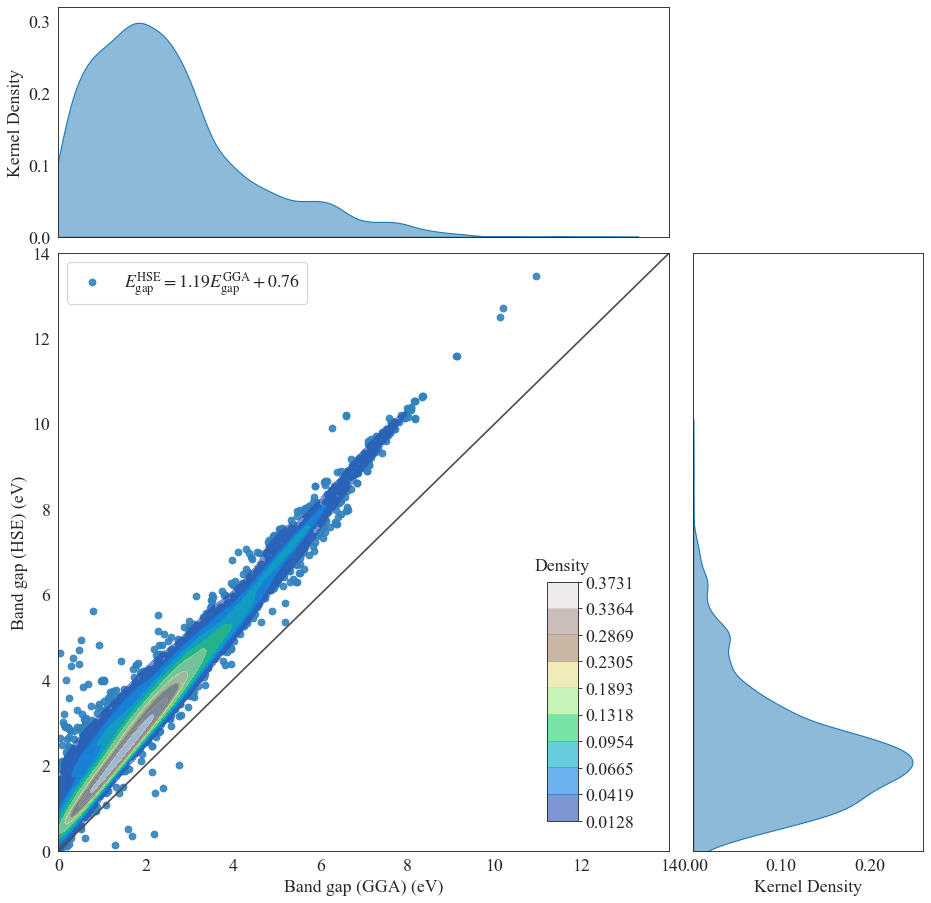

In [7]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats
import matplotlib as mpl
%matplotlib inline
sns.set_style('white')

fig = plt.figure(figsize=(16, 16), dpi= 80)
gs = plt.GridSpec(8, 8, hspace=0.15, wspace=0.23)
mpl.rcParams['font.family'] = 'Times New Roman'
ax1 = fig.add_subplot(gs[0:2, :5])
sns.kdeplot(data=df1, x='GGA',ax=ax1, color='#1f77b4', fill=True, alpha=0.5, shade=True)

ax1.set_xticks([])
ax1.set_xlabel(None)
ax1.set_ylabel('Kernel Density')
ax1.set_xlim(left=0)
ax1.set_ylim([0, 0.32])
ax3 = fig.add_subplot(gs[2:7, :5])

ax3.scatter('GGA', 'HSE', data=df1, alpha=.9, cmap="tab10", color='#3182bd',
            label=r'$ E_{\mathrm{gap}}^{\mathrm{HSE}} =  1.19 E_{\mathrm{gap}}^{\mathrm{GGA}} + 0.76 $')
ax3.legend()
cbar_ax =  ax3.inset_axes([0.8, 0.05, 0.05, 0.4])
cbar_ax.set_title('Density', pad=10)
kde = sns.kdeplot(data=df1, x='GGA', y='HSE', cmap='terrain',
                  shade=True, cbar=True, cbar_ax=cbar_ax,shade_lowest=False, ax=ax3, alpha=0.6)
ax3.set_xlim([0, 14])
ax3.set_ylim([0, 14])
ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="-", c=".3")

#Calculate the regression line and get its equation
#slope, intercept, r_value, p_value, std_err = stats.linregress(df1['GGA'], df1['HSE'])
#line = f'Eg(HSE) = {slope:.2f} \u00B7 Eg(GGA) + {intercept:.2f}'

#ax3.annotate(line, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=20)

ax3.set_xlabel('Band gap (GGA) (eV)')
ax3.set_ylabel('Band gap (HSE) (eV)')

ax4 = fig.add_subplot(gs[2:7, 5:7])
sns.kdeplot(data=df1, y='HSE', ax=ax4, color='#1f77b4', fill=True, alpha=0.5, shade=True)

import matplotlib.ticker as mtick

ax4.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

ax4.set_ylabel(None)
ax4.set_yticks([])
ax4.set_xlabel('Kernel Density')
ax4.set_xlim(left=0)
ax4.set_ylim([0, 20])

plt.tight_layout()
#plt.show()
plt.savefig('./figures/figure1.png', dpi=300, bbox_inches='tight')

In [8]:
mp_data = pd.read_csv("./data/mp_data_new.csv",index_col=0)
mp_data = mp_data.rename(columns={'formula_pretty':'formula','symmetry':'spacegroup','band_gap':'GGA'})
mp_data = mp_data[['formula','spacegroup','GGA','formation_energy_per_atom','energy_above_hull']]
mp_data = mp_data.dropna(subset=['formula','spacegroup'])
mp_data['index'] = mp_data.index

In [9]:
# Convert to the same chemical formula format
hse_data['formula'] = hse_data['formula'].map(lambda x:Composition(x).reduced_formula)
mp_data['formula'] = mp_data['formula'].map(lambda x:Composition(x).reduced_formula)

In [10]:
#pick out some data https://docs.materialsproject.org/methodology/materials-methodology/electronic-structure/
mp_data['composition'] = mp_data['formula'].map(Composition)
mp_data['is_GGA_U'] = mp_data['composition'].map(lambda x : 1 if ('Co' in x and 'O' in x) or ('Co' in x and 'F' in x)
                                                 or ('Cr'in x and 'O' in x) or ('Cr' in x and 'F' in x)
                                                 or ('Fe'in x and 'O' in x) or ('Fe' in x and 'F' in x)
                                                 or ('Mn'in x and 'O' in x and x.reduced_formula != 'Mn2O3') or ('Mn' in x and 'F' in x)
                                                 or ('Mo'in x and 'O' in x) or ('Mo' in x and 'F' in x)
                                                 or ('Ni'in x and 'O' in x) or ('Ni' in x and 'F' in x)
                                                 or ('V'in x and 'O' in x and x.reduced_formula != 'VO') or ('V' in x and 'F' in x)
                                                 or ('W'in x and 'O' in x) or ('W' in x and 'F' in x)
                                                 else 0
                                                )
mp_data['is_GGA_U'].value_counts()

0    111777
1     42938
Name: is_GGA_U, dtype: int64

In [11]:
mp_data_U = mp_data[mp_data['is_GGA_U']==1]
mp_data_non_U = mp_data[mp_data['is_GGA_U']==0]

In [12]:
# take the intersection
inner_val = pd.merge(hse_data,mp_data_non_U, on=['formula','spacegroup'], how='inner')
inner_val

,formula,HSE,GGA_x,spacegroup,free_energy,index_x,composition_x,GGA_y,formation_energy_per_atom,energy_above_hull,index_y,composition_y,is_GGA_U
0,Cu2GeSe3,0.357144,0.057361,9.0,-3.574910,1,"(Cu, Ge, Se)",0.0000,-0.477014,0.004076,145377,"(Cu, Ge, Se)",0
1,Na2CoCl4,4.477341,2.780673,62.0,-3.567538,2,"(Cl, Co, Na)",0.0192,-1.650927,0.000000,101779,"(Na, Co, Cl)",0
2,NaCrSe2,1.138949,0.407413,166.0,-4.752246,3,"(Cr, Na, Se)",0.7808,-1.044310,0.000000,66800,"(Na, Cr, Se)",0
3,Al2Fe3Si4,0.000000,0.000000,63.0,-6.420703,4,"(Al, Fe, Si)",0.0000,-0.398392,0.010081,135106,"(Al, Fe, Si)",0
4,LaNi4B,0.000000,0.000000,191.0,-6.000872,5,"(B, La, Ni)",0.0000,-0.416482,0.000000,124033,"(La, Ni, B)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14470,LaCuTeO,2.246626,1.417926,129.0,-5.791982,13624,"(Cu, La, O, Te)",1.1839,-2.177789,0.008628,82121,"(La, Cu, Te, O)",0
14471,La3CuS3O2,1.871609,1.088934,62.0,-6.802721,13625,"(Cu, La, O, S)",0.9670,-2.742169,0.000000,84374,"(La, Cu, S, O)",0
14472,La3GaS5O,1.968560,1.153778,62.0,-6.389724,13630,"(Ga, La, O, S)",1.2434,-2.395346,0.000000,9807,"(La, Ga, S, O)",0
14473,In6Ga2PtO8,1.503397,0.613842,225.0,-5.429347,13631,"(Ga, In, O, Pt)",0.5672,-1.778338,0.000000,147398,"(In, Ga, Pt, O)",0


In [13]:
# Keep the closest result calculated by GGA
inner_val['GGA_err'] = np.abs(inner_val['GGA_x'] -  inner_val['GGA_y'])
inner_val = inner_val.groupby(['formula','spacegroup'],as_index=False).min(['GGA_err'])
keeped_data = inner_val
inner_val

,formula,spacegroup,HSE,GGA_x,free_energy,index_x,GGA_y,formation_energy_per_atom,energy_above_hull,index_y,is_GGA_U,GGA_err
0,Ag,194.0,0.000000,0.00000,-2.721318,4650,0.0000,0.007226,0.007226,50331,0,0.00000
1,Ag(AuF4)2,14.0,2.060208,0.29665,-3.233511,2106,0.2585,-1.385379,0.000000,108057,0,0.03815
2,Ag(Bi2S3)3,12.0,0.000000,0.00000,-4.253158,980,0.0000,-0.592917,0.029380,139197,0,0.00000
3,Ag(CO)2,15.0,2.428665,1.20222,-6.585129,11919,0.7248,-0.646890,0.415317,131244,0,0.47742
4,Ag(Mo3Se4)2,148.0,0.000000,0.00000,-6.886230,1802,0.0000,-0.714146,0.076030,24039,0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
10726,ZrVGe,139.0,0.000000,0.00000,-7.972034,12348,0.0000,-0.662724,0.000000,58118,0,0.00000
10727,ZrW2,227.0,0.000000,0.00000,-11.656033,10390,0.0000,-0.145862,0.000000,92329,0,0.00000
10728,ZrZn,221.0,0.000000,0.00000,-5.101354,11114,0.0000,-0.287190,0.000000,89434,0,0.00000
10729,ZrZn2,227.0,0.000000,0.00000,-3.880027,5606,0.0000,-0.302553,0.000000,96359,0,0.00000


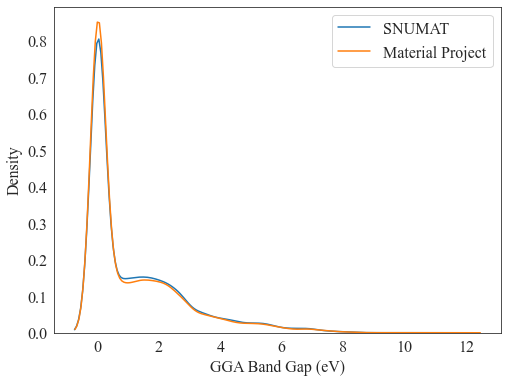

In [14]:
plt.figure(figsize=(8,6))
sns.kdeplot(inner_val['GGA_x'],label='SNUMAT')
sns.kdeplot(inner_val['GGA_y'],label='Material Project')
plt.xlabel('GGA Band Gap (eV)')
plt.legend()
plt.show()

# 数据处理

In [15]:
# Handle data with the same chemical formula and space group
def handle_with_the_same_formula_and_spacegroup(df):
    # 找出化学式重复的数据
    formula_repeat_data = df[df[["formula"]].duplicated(keep=False)]
    formula_repeat_data = formula_repeat_data.sort_values('formula')
    # 化学式与空间群同时重复的数据
    formula_and_spacegroup_repeat_data = formula_repeat_data[formula_repeat_data[["formula",'spacegroup']].duplicated(keep=False)]
    formula_and_spacegroup_repeat_data = formula_and_spacegroup_repeat_data.sort_values('formula')
    # 对化学式与空间群同时重复的数据建立唯一映射,后面改成能量
    formula_and_spacegroup_repeat_data['index'] = formula_and_spacegroup_repeat_data.index
    keeped_repeat_spacegroup_data = pd.DataFrame()
    if 'formation_energy_per_atom' in df.columns and 'energy_above_hull' in df.columns:
        keeped_repeat_spacegroup_data = formula_and_spacegroup_repeat_data.groupby(['formula','spacegroup'],
                                                                                   as_index=False).min(['formation_energy_per_atom',
                                                                                                        'energy_above_hull'])
    elif 'free_energy' in df.columns:
        keeped_repeat_spacegroup_data = formula_and_spacegroup_repeat_data.groupby(['formula','spacegroup'],as_index=False).min(['free_energy'])
    
    keeped_repeat_spacegroup_data.index = keeped_repeat_spacegroup_data['index']
    keeped_repeat_spacegroup_data = keeped_repeat_spacegroup_data.drop(columns='index')
    # 对化学式与空间群都重复的数据去除，但是保留唯一映射
    droped_repeat_spacegroup_data = formula_repeat_data.drop(index = formula_and_spacegroup_repeat_data.index)
    df = df.drop(index = formula_and_spacegroup_repeat_data.index)
    # 拼接处理过后能唯一映射的数据
    df = pd.concat([df,keeped_repeat_spacegroup_data],axis=0)
    return df

In [16]:
hse_data = handle_with_the_same_formula_and_spacegroup(hse_data)

In [17]:
def remove_single_element(data):
    # delete a single element
    data['composition'] = data['formula'].map(Composition)
    data['is_single_element'] = data['composition'].map(lambda x: 1 if len(x)==1 else 0)
    data = data[data['is_single_element']==0]
    data = data.drop(columns = 'is_single_element')
    return data
hse_data = remove_single_element(hse_data)

In [18]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
data = feature_calculators.featurize_dataframe(hse_data, col_id='composition');
feature_labels = feature_calculators.feature_labels()
X = data[feature_labels]

MultipleFeaturizer:   0%|          | 0/12775 [00:00<?, ?it/s]

In [19]:
hse_data['is_metal'] = hse_data['HSE'].map(lambda x: 0 if x>0 else 1)
y = hse_data['is_metal']

In [20]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''  
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    return x

In [21]:
# 剔除共线性特征
X = data[feature_labels]
X = remove_collinear_features(X, 0.8);
feature_labels = X.columns
if 'spacegroup' not in feature_labels:
    feature_labels = feature_labels.insert(-1,'spacegroup')
X = data[feature_labels]

# 空间群重要性分析

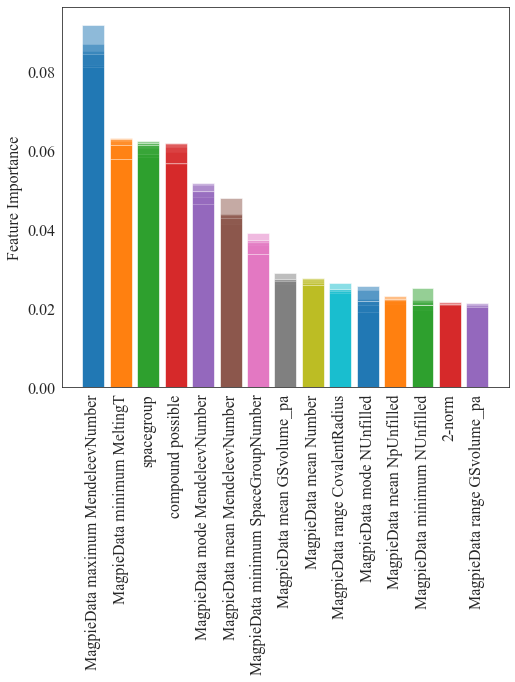

In [22]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
X = X.dropna()
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
feature_importances_list = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf.fit(X_train, y_train)

    feature_importances = rf.feature_importances_

    feature_importances_list.append(feature_importances)

feature_importances_df = pd.DataFrame(feature_importances_list, columns=X.columns)

mean_feature_importances = feature_importances_df.mean()

top_features_names = mean_feature_importances.sort_values(ascending=False)[:15].index.tolist()

fig, ax = plt.subplots(figsize=(8, 7))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, feature in enumerate(top_features_names):
    feature_importances = feature_importances_df[feature].values
    ax.bar(feature, mean_feature_importances[feature], color=colors[i%len(colors)], alpha=0.5)
    ax.bar(feature, feature_importances, color=colors[i%len(colors)], alpha=0.5)

ax.set_xticklabels(top_features_names, rotation=90)
ax.set_ylabel('Feature Importance')

plt.show()

In [24]:
feature_x = pd.DataFrame({'Feature': top_features_names, 'Importance':mean_feature_importances[top_features_names]})
#feature_x = feature_importances.reset_index(drop=True)
feature_x['feature'] = ['x'+str(i) for i in range(1,16)]

feature_x

,Feature,Importance,feature
MagpieData maximum MendeleevNumber,MagpieData maximum MendeleevNumber,0.085254,x1
MagpieData minimum MeltingT,MagpieData minimum MeltingT,0.061484,x2
spacegroup,spacegroup,0.060618,x3
compound possible,compound possible,0.059583,x4
MagpieData mode MendeleevNumber,MagpieData mode MendeleevNumber,0.049422,x5
MagpieData mean MendeleevNumber,MagpieData mean MendeleevNumber,0.043921,x6
MagpieData minimum SpaceGroupNumber,MagpieData minimum SpaceGroupNumber,0.036538,x7
MagpieData mean GSvolume_pa,MagpieData mean GSvolume_pa,0.027176,x8
MagpieData mean Number,MagpieData mean Number,0.026743,x9
MagpieData range CovalentRadius,MagpieData range CovalentRadius,0.024638,x10


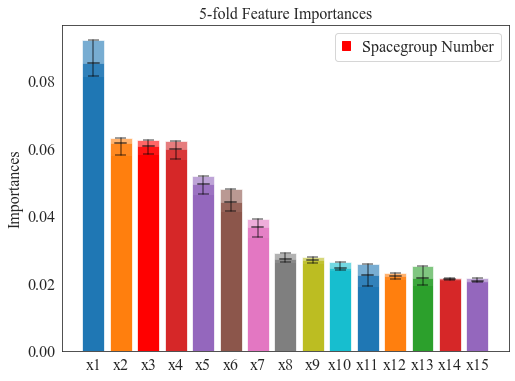

In [27]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(8, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, feature in enumerate(top_features_names):
    feature_importances = feature_importances_df[feature].values
    if i == 2:
        ax.bar(feature, feature_importances.min(), color='red', alpha=1)
        ax.bar(feature, mean_feature_importances[feature], color='red', alpha=0.8, label='Spacegroup')
        ax.bar(feature, feature_importances.max(), color='red', alpha=0.6)
    else:
        ax.bar(feature, feature_importances.min(), color=colors[i%len(colors)], alpha=1)
        ax.bar(feature, mean_feature_importances[feature], color=colors[i%len(colors)], alpha=0.8)
        ax.bar(feature, feature_importances.max(), color=colors[i%len(colors)], alpha=0.6)
    #error bars
    mean_importance = mean_feature_importances[feature]
    max_importance = feature_importances.max()
    min_importance = feature_importances.min()

    ax.plot([i, i], [min_importance, max_importance], lw=1.5, c='black',alpha=0.5)
    ax.hlines([min_importance, max_importance], i-0.2, i+0.2, lw=1.5, colors='black',alpha=0.5)
    ax.plot([i-0.2, i+0.2], [mean_importance, mean_importance], lw=2, c='black',alpha=0.5)

ax.set_xticklabels(feature_x['feature'])
ax.set_ylabel('Importances')
ax.set_title('5-fold Feature Importances')

#rects = ax.patches
#hist_5_pos = rects[4].get_xy()
#hist_5_height = rects[4].get_height()

# legend
handles = [mpatches.Patch(facecolor='red', edgecolor='red', alpha=1)]
labels = ['Spacegroup Number']
ax.legend(handles=handles, labels=labels, loc='upper right', handlelength=0.5, handleheight=0.5)

#plt.show()
plt.savefig('./figures/5_fold_imp.png', dpi=300, bbox_inches='tight')